In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import scipy.io as scio
import math
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
class time_series_decoder_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        # time points
        #self.x = torch.cat(3*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        path = r'/home/ubuntu/TargetTracking_datasets/POImotiondata track/motion track/Invivo-I.mat'
        matdata = scio.loadmat(path)
        data = []
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])
        for i in range(N):
            data_x = []
            if ( N >= 500 ):
                #data_x.append(matdata['SquPOI'][0][i:i+25])
                #data_x.append(matdata['Poi'][0][i:i+25])
                data_x.append(matdata['Poi'][0][i:i+48])
                data_x.append(matdata['Poi'][1][i:i+48])
                data_x.append(matdata['Poi'][2][i:i+48])
                #print(len(data_x))
                data.append(data_x)
        
            else:
                data_x.append(matdata['Poi'][0][575+i:575+i+48])
                data_x.append(matdata['Poi'][1][575+i:575+i+48])
                data_x.append(matdata['Poi'][2][575+i:575+i+48])
                data.append(data_x)
        data = np.array(data)
        self.fx = torch.from_numpy(data)
        self.fx = self.fx.type(torch.FloatTensor)       
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        self.masks = self._generate_square_subsequent_mask(t0)
                
        
         # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        sample = (self.x[idx,:],
                  self.fx[idx,:],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(t0+24,t0+24)
        for i in range(0,t0):
            mask[i,t0:] = 1
        for i in range(t0,t0+24):
            mask[i,i+24:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

In [3]:
t0 = 24

In [4]:
train_dataset = time_series_decoder_paper(t0,575)
validation_dataset = time_series_decoder_paper(t0,100)
test_dataset = time_series_decoder_paper(t0,100)

x: 575*48 fx: 575*3
x: 100*48 fx: 100*3
x: 100*48 fx: 100*3


In [5]:
train_dataset.x.shape

torch.Size([575, 48])

In [6]:
train_dataset.fx.shape

torch.Size([575, 3, 48])

In [7]:
train_dl = DataLoader(train_dataset,batch_size=1,shuffle=False)
validation_dl = DataLoader(validation_dataset,batch_size=1,shuffle=False)
test_dl = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [8]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self,in_channels=1,embedding_size=256,k=5):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self,x):
        x = self.causal_convolution(x)
        return torch.tanh(x)



In [9]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = context_embedding(4,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,3)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        y=y.squeeze(0)
        attention_masks=attention_masks.squeeze(0)
        z = torch.cat((y,x),0)
        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z)
        #z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings =self.positional_embedding(x.type(torch.long)).squeeze(0)
        
        input_embedding = z_embedding.permute(1,0)+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)
        
        output = self.fc1(transformer_embedding).permute(1,0)
        
        #print(output.shape)
        
        return output
        

In [10]:
criterion = torch.nn.MSELoss()

In [11]:
model = TransformerTimeSeries().cuda()

In [12]:
lr = .0005 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 30

In [13]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [14]:
def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [15]:
def train_epoch(model,train_dl,t0=24):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        #print(output.squeeze()[:,:].shape)
        #print(output.squeeze()[:,(t0)])
        #print(y.cuda().squeeze(0)[:,(t0)])
        #print(c)
        loss = criterion(output.squeeze()[:,t0:],y.cuda().squeeze(0)[:,t0:]) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [16]:
def eval_epoch(model,validation_dl,t0=24):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,t0:],y.cuda().squeeze(0)[:,t0:]) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [17]:
def test_epoch(model,test_dl,t0=24):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            #loss = criterion(output.squeeze()[:,(t0-1):(t0+100-1)],y.cuda().squeeze()[:,(t0-1):(t0+100-1)])
            for p,o in zip(output.squeeze()[:,t0:].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data
                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [18]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_t = train_epoch(model,train_dl,t0)
    train_loss.append(l_t)
    
    l_e = eval_epoch(model,validation_dl,t0)
    eval_loss.append(l_e)
    
    Rp = test_epoch(model,test_dl,t0)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print("Epoch {}: Train loss: {} \t Validation loss: {} \t R_p={}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss),Rp))

/home/ubuntu/anaconda3/envs/siamfc/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Epoch 0: Train loss: 48.487942451912424 	 Validation loss: 2.019978986978531 	 R_p=nan
Epoch 1: Train loss: 1.268089541144993 	 Validation loss: 2.01281240105629 	 R_p=nan
Epoch 2: Train loss: 1.0902405072295147 	 Validation loss: 1.5120661675930023 	 R_p=nan
Epoch 3: Train loss: 0.5845687305927276 	 Validation loss: 0.947018001973629 	 R_p=nan
Epoch 4: Train loss: 0.29794793573410616 	 Validation loss: 0.6765706181526184 	 R_p=nan
Epoch 5: Train loss: 0.18699363106618758 	 Validation loss: 0.4055968667566776 	 R_p=nan
Epoch 6: Train loss: 0.1626168254147405 	 Validation loss: 0.303628213852644 	 R_p=nan
Epoch 7: Train loss: 0.14861241045853366 	 Validation loss: 0.380268874168396 	 R_p=nan
Epoch 8: Train loss: 0.14145186240258426 	 Validation loss: 0.2975226248055696 	 R_p=nan
Epoch 9: Train loss: 0.13428881338757018 	 Validation loss: 0.4584744442999363 	 R_p=nan
Epoch 10: Train loss: 0.12907883335714754 	 Validation loss: 0.3078563271090388 	 R_p=nan
Epoch 11: Train loss: 0.12584750

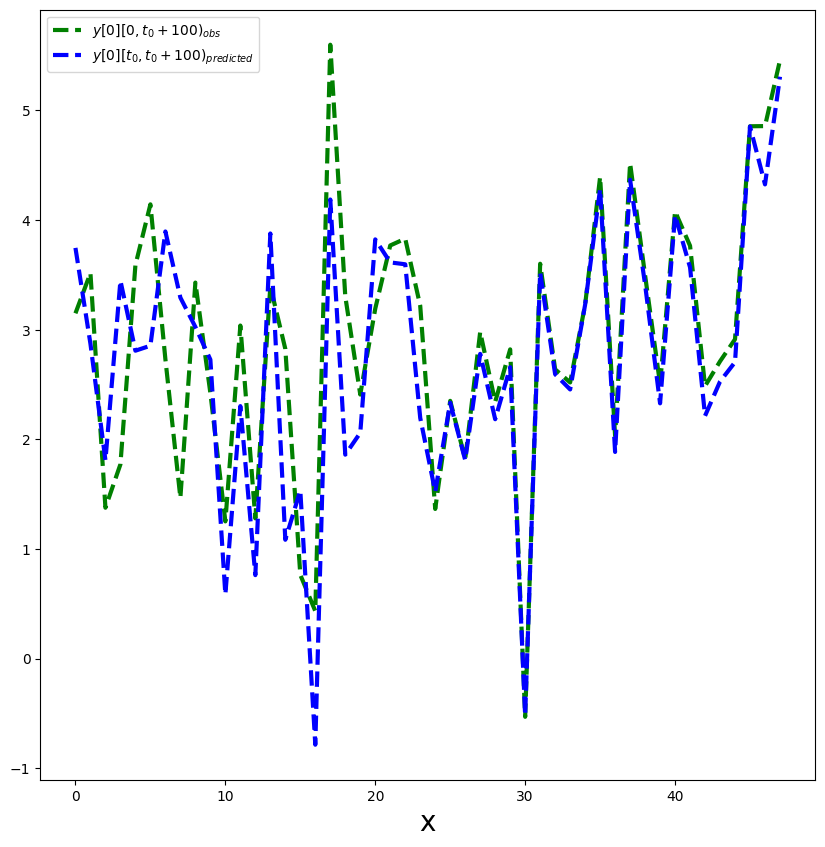

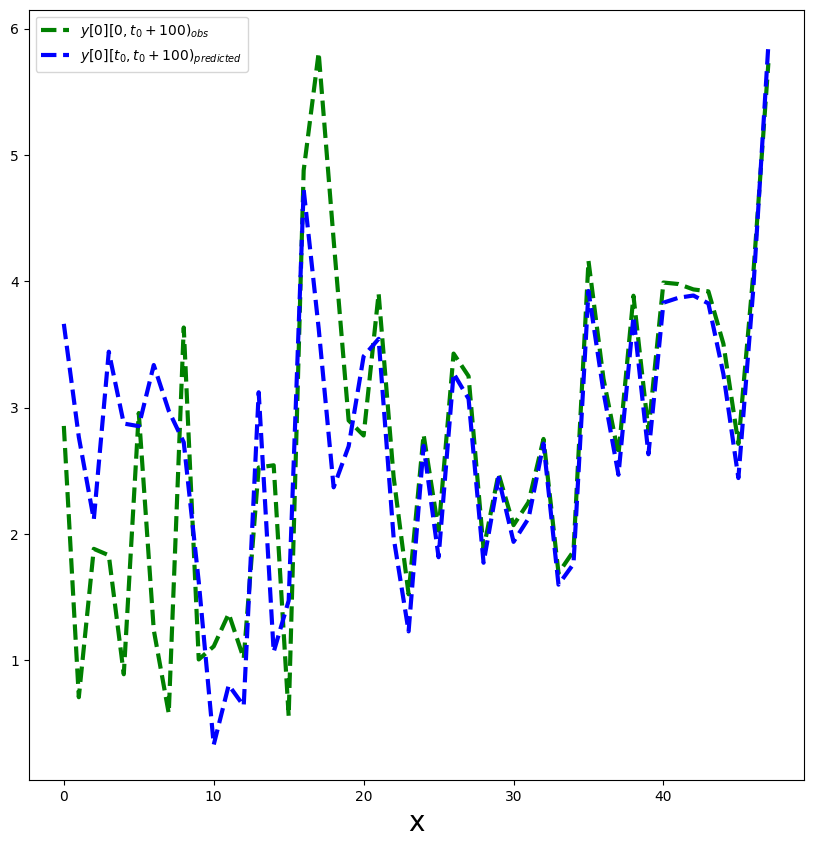

In [19]:
n_plots = 1
res = []
rel = []
tem=np.zeros((3,1))
tem = test_dl.dataset.fx
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            #print(attention_masks.shape)
            if step>0:
                y[0][0][t0-1]=torch.tensor(tem[0])
                y[0][1][t0-1]=torch.tensor(tem[1])
                y[0][2][t0-1]=torch.tensor(tem[2])
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            #output.permute(1,0)[t0])
            tem=output.permute(1,0).cpu().numpy()[t0]
            #print(output.)
            #break
            res.append(tem)

            if step > n_plots:
                continue

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0][0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x.cpu().detach().squeeze().numpy(),output[0].cpu().detach().squeeze().numpy(),'b--',linewidth=3)
                plt.xlabel("x",fontsize=20)
                plt.legend(["$y[0][0,t_0+100)_{obs}$","$y[0][t_0,t_0+100)_{predicted}$"])
                plt.show()


In [20]:
y1=test_dl.dataset.fx.permute(2,1,0)[t0].numpy()

In [21]:
y2=np.array(res)
y2=y2.transpose(1,0)

In [22]:
sum = 0
mse = []
for j in range (100):
    for i in range (3):
        a = (y1[i][j]-y2[i][j])*(y1[i][j]-y2[i][j])
        sum += a
        #print(((j)*3+(i+1)))
    mse.append(sum/((j)*3+(i+1)))

In [23]:
mse_ = sum / 300 

In [24]:
mse_

0.16067703405882638

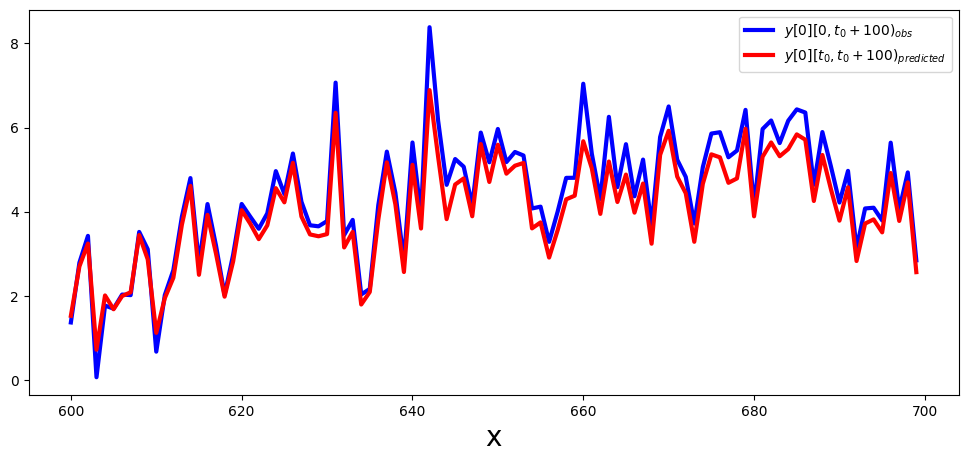

In [25]:
x = np.arange(600,700)
plt.figure(1, figsize=(12, 5))
plt.ion()
                #print(x[0].cpu().detach().squeeze().shape)
                #print(y[0][0].cpu().detach().squeeze().shape)
plt.plot(x,y1[0],'b-',linewidth=3)
#print(x.cpu().detach().squeeze().shape)
        #print(output[0].cpu().detach().squeeze().shape)
plt.plot(x,y2[0],'r-',linewidth=3)
#plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,t0:].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # not missing data
 # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
plt.xlabel("x",fontsize=20)
plt.legend(["$y[0][0,t_0+100)_{obs}$","$y[0][t_0,t_0+100)_{predicted}$"])
plt.show()

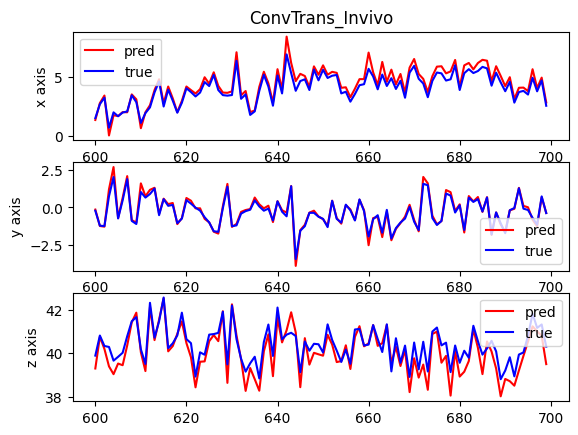

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
l1, = ax1.plot(x,y1[0],color = 'red')
l2, = ax1.plot(x,y2[0],color = 'blue')
plt.legend([l1,l2],['pred','true'])
plt.ylabel("x axis")
plt.title("ConvTrans_{}".format("Invivo"))
ax1 = fig.add_subplot(312)
l3, = ax1.plot(x,y1[1],color = 'red')
l4, = ax1.plot(x,y2[1],color = 'blue')
plt.legend([l3,l4],['pred','true'])
plt.ylabel("y axis")
ax1 = fig.add_subplot(313)
l5, = ax1.plot(x,y1[2],color = 'red')
l6, = ax1.plot(x,y2[2],color = 'blue')
plt.legend([l5,l6],['pred','true'])
plt.ylabel("z axis")
plt.show()